# Nosing-denoising analysis

This notebook is used to analyze the results of the noising-denoising test and help select the appropriate *diffusion timestep* (or *noise schedule*) for your task.

In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import jax.tree_util as jtu
import sys
import os
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.rdBase import BlockLogs
from rdkit.Chem import AllChem, DataStructs
from scipy.optimize import curve_fit

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import expand_batch_dim

## Define tool functions

In [4]:
### function for calculating reconstruction accuracy.
def hit(x, y, beam_size = 4,):
    ### x: shape of (beam_size,), infer smiles; y: shape of (1,) true canonical smiles
    _h = []
    y = Chem.MolToSmiles(Chem.MolFromSmiles(y))
    for i in range(beam_size):
        smi = x[i]
        try:
            with BlockLogs():
                g = Chem.MolFromSmiles(smi, sanitize = True)
                cs = Chem.MolToSmiles(g, canonical = True, isomericSmiles = True)
            if cs == y:
                _h.append(0) ## correct
            else:
                _h.append(1) ## valid
        except:
            _h.append(2) ## invalid
    return np.asarray(_h)

In [5]:
### function for calculating tanimoto similarity
def tani_sim(x, y, beam_size = 4,):
    ### x: shape of (4,), infer smiles; y: shape of (1,) true canonical smiles
    _h = []
    y = Chem.MolToSmiles(Chem.MolFromSmiles(y))
    for i in range(beam_size - 1, -1, -1):
        smi = x[i]
        try:
            with BlockLogs():
                g = Chem.MolFromSmiles(smi, sanitize = True)
                cs = Chem.MolToSmiles(g, canonical = True, isomericSmiles = True)
            if cs == y:
                return 1
            else:
                fp_y = AllChem.GetMorganFingerprintAsBitVect(g, 2, nBits = 2048)
                fp_x = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(y), 2, nBits = 2048)
                return DataStructs.FingerprintSimilarity(fp_x, fp_y)
        except:
            continue
    return 0

In [6]:
### function for calculating substructure retain rate
def has_substructure(x, y, beam_size = 4,):
    ### x: shape of (4,), infer smiles; y: shape of (1,) true canonical smiles
    _h = []
    y = Chem.MolFromSmiles(y)
    for i in range(beam_size - 1, -1, -1):
        smi = x[i]
        try:
            with BlockLogs():
                g = Chem.MolFromSmiles(smi, sanitize = True)
            if g.HasSubstructMatch(y):
                return 1
        except:
            continue
    return 0

In [7]:
### calculating diversity
def diversity(smi):
    ## smi: shape of (n, 4)
    valid_smiles = []
    for bm in smi:
        ## bm: (4,)
        for i in range(bm.shape[0] - 1, -1, -1):
            try:
                with BlockLogs():
                    g = Chem.MolFromSmiles(bm[i], sanitize=True)
                valid_smiles.append(bm[i])
                break
            except:
                continue
    return len(set(valid_smiles)) / len(valid_smiles)

In [8]:
def main(output_smiles_list, original_smiles, sub_smiles):
    accs, valids, has_subs, sims, divers = [], [], [], [], []
    for output_smiles in output_smiles_list:
        n, _ = output_smiles.shape
        hit_array = np.zeros(shape = output_smiles.shape)
        has_sub_array = np.zeros(shape = (n,))
        sim_array = np.zeros(shape = (n,))
        for i in range(n):
            hit_array[i] = hit(output_smiles[i], original_smiles[0])
            has_sub_array[i] = has_substructure(output_smiles[i], sub_smiles)
            sim_array[i] = tani_sim(output_smiles[i], original_smiles[0])
        hit_array_min = np.min(hit_array, axis = -1)
        acc = np.sum(hit_array_min == 0) / np.size(hit_array_min)
        accs.append(acc)
        v = np.sum(hit_array_min == 2) / np.size(hit_array_min) ## not valid...
        valids.append(1 - v)
        has_subs.append(has_sub_array)
        sims.append(sim_array)
        divers.append(diversity(output_smiles))
    return accs, valids, has_subs, sims, divers

## Calculating the above metrics

In [9]:
with open(f'init_molecule/init_search_molecule.pkl', 'rb') as f:
    init_mol = pkl.load(f)

In [10]:
### we use ar-gr case as an example
original_smiles = str(init_mol['smiles']) # the input initial molecule
sub_smiles = 'O=C(N1CCNCC1)c1ccccc1' # the substructure that we want to retain
fn_noising_retain = './init_molecule/noising-denoising_test.pkl' # the output file from noising-denoising_test.py

original_smiles = np.array(original_smiles)
with open(fn_noising_retain, 'rb') as f:
    output_smiles_list = pkl.load(f)
original_smiles = expand_batch_dim(output_smiles_list[0].shape[0], original_smiles)
print(original_smiles.shape)

accs_ar, valids_ar, has_subs_ar, sims_ar, divers_ar = main(output_smiles_list, original_smiles, sub_smiles)

(128,)


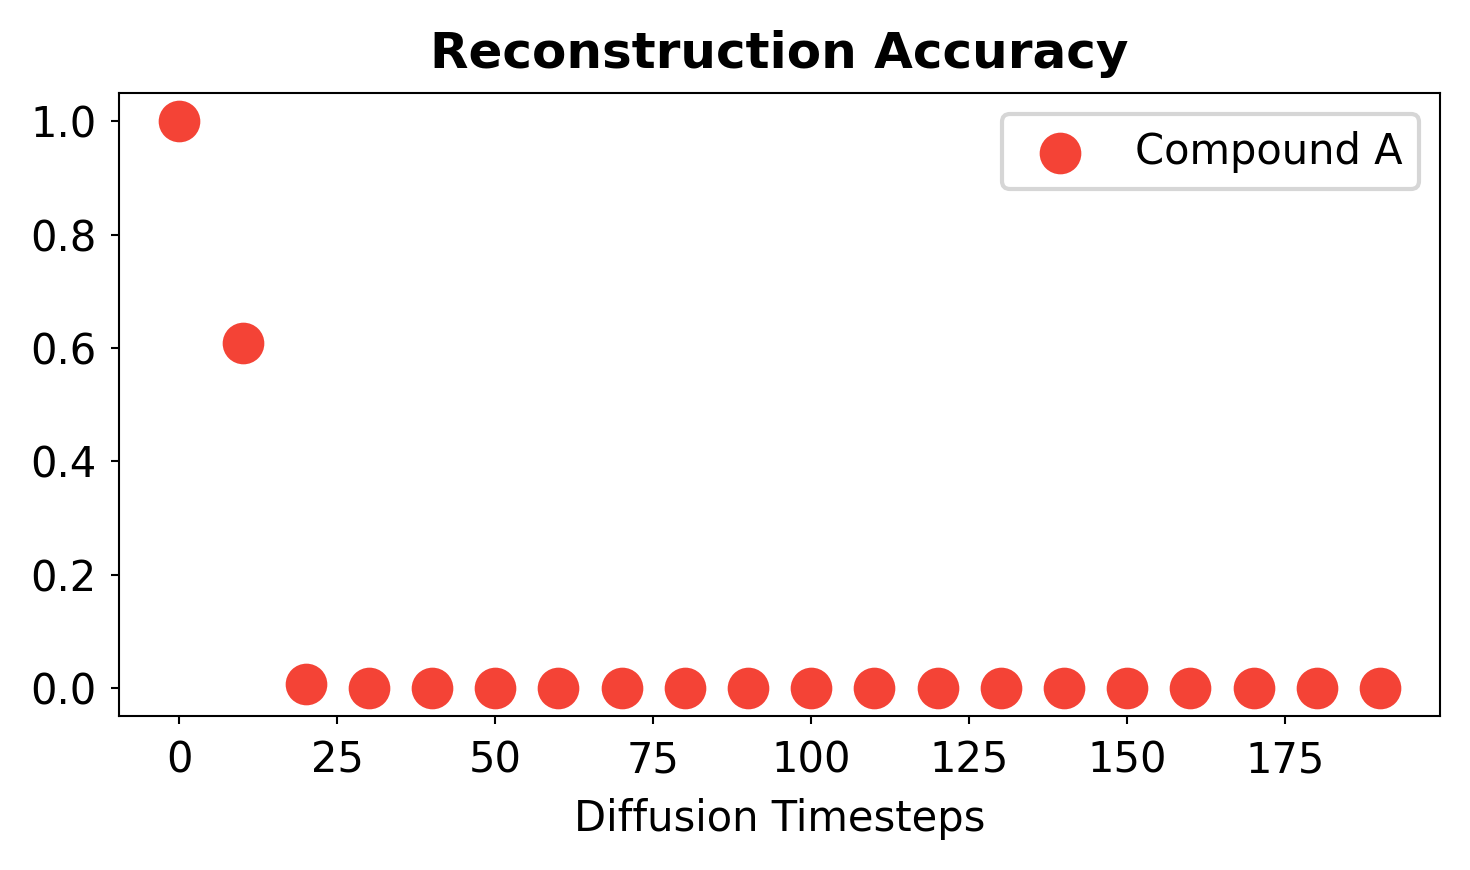

In [11]:
### reconstruction accuracy
time_steps = np.arange(0, 200, 10)
dpi = 300
bwith = 0.5
colors = iter(['#F44336', '#4CAF50', '#1565C0'])

def plot_fn(accs, ax, label=''):
    c_ = next(colors)
    time_steps_fine = np.arange(0, 200, 500)
    ax.scatter(x=time_steps, y=accs, alpha=1., marker='o', label=label,
               edgecolors='w', linewidths=0, s=100, color=c_)


plt.figure(figsize=(5, 3), dpi=dpi)
ax = plt.gca()
ax.spines[:].set_linewidth(bwith)
ax.tick_params(axis='both', which='major', width=bwith, length=2)
plot_fn(accs_ar, ax, label='Compound A')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.xlabel('Diffusion Timesteps')
plt.title('Reconstruction Accuracy', weight='bold')
plt.tight_layout()
plt.show()

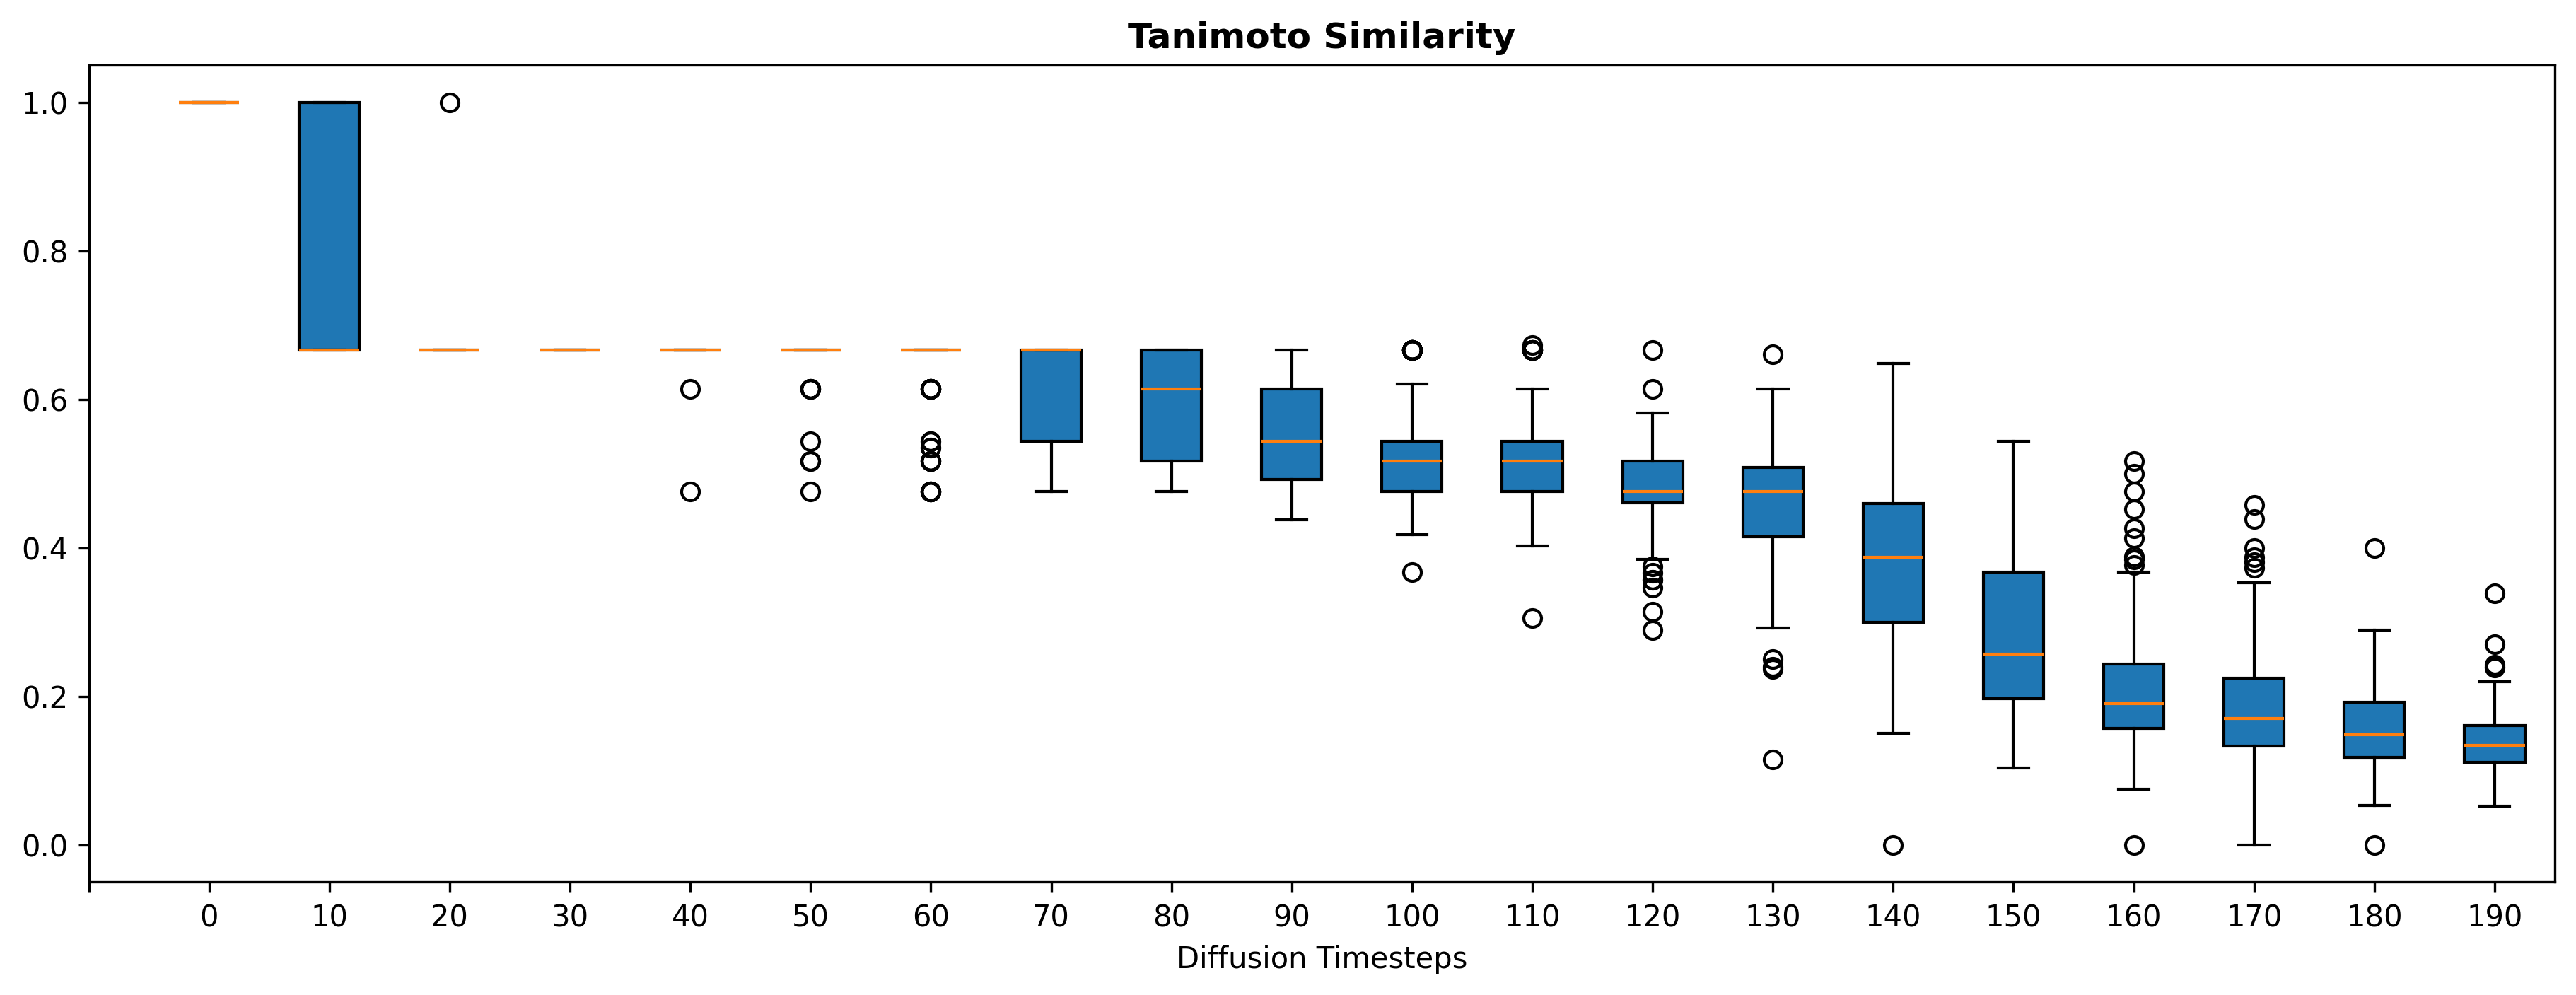

In [12]:
### Tanimoto similarity
plt.figure(figsize=(15, 5), dpi=300)
plt.boxplot(sims_ar, vert=True, patch_artist=True)
plt.xticks(np.arange(21), [''] + [f'{i}' for i in range(0, 200, 10)])
plt.xlabel('Diffusion Timesteps')
plt.title('Tanimoto Similarity', x=0.5, y=1., weight='bold')
plt.show()

/tmp/ipykernel_1815940/1045833896.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)


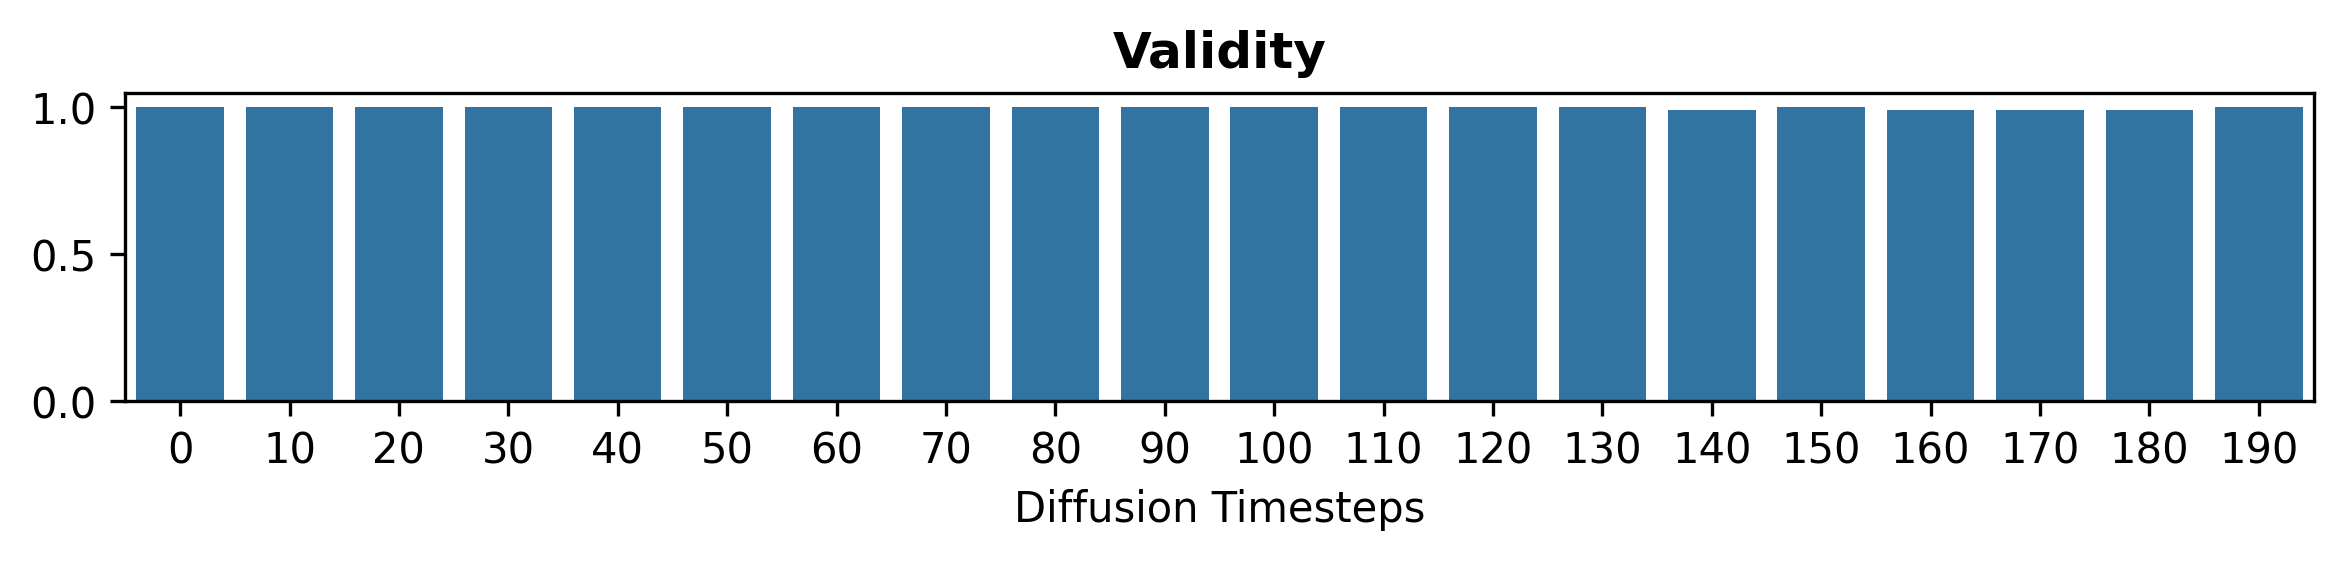

In [13]:
## validity
plt.figure(figsize=(8, 2), dpi=300)
sns.barplot(x=list(range(0, 200, 10)), y=valids_ar,)
plt.xlabel('Diffusion Timesteps')
plt.ylabel(None)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
plt.title('Validity', weight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1815940/3947324497.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)


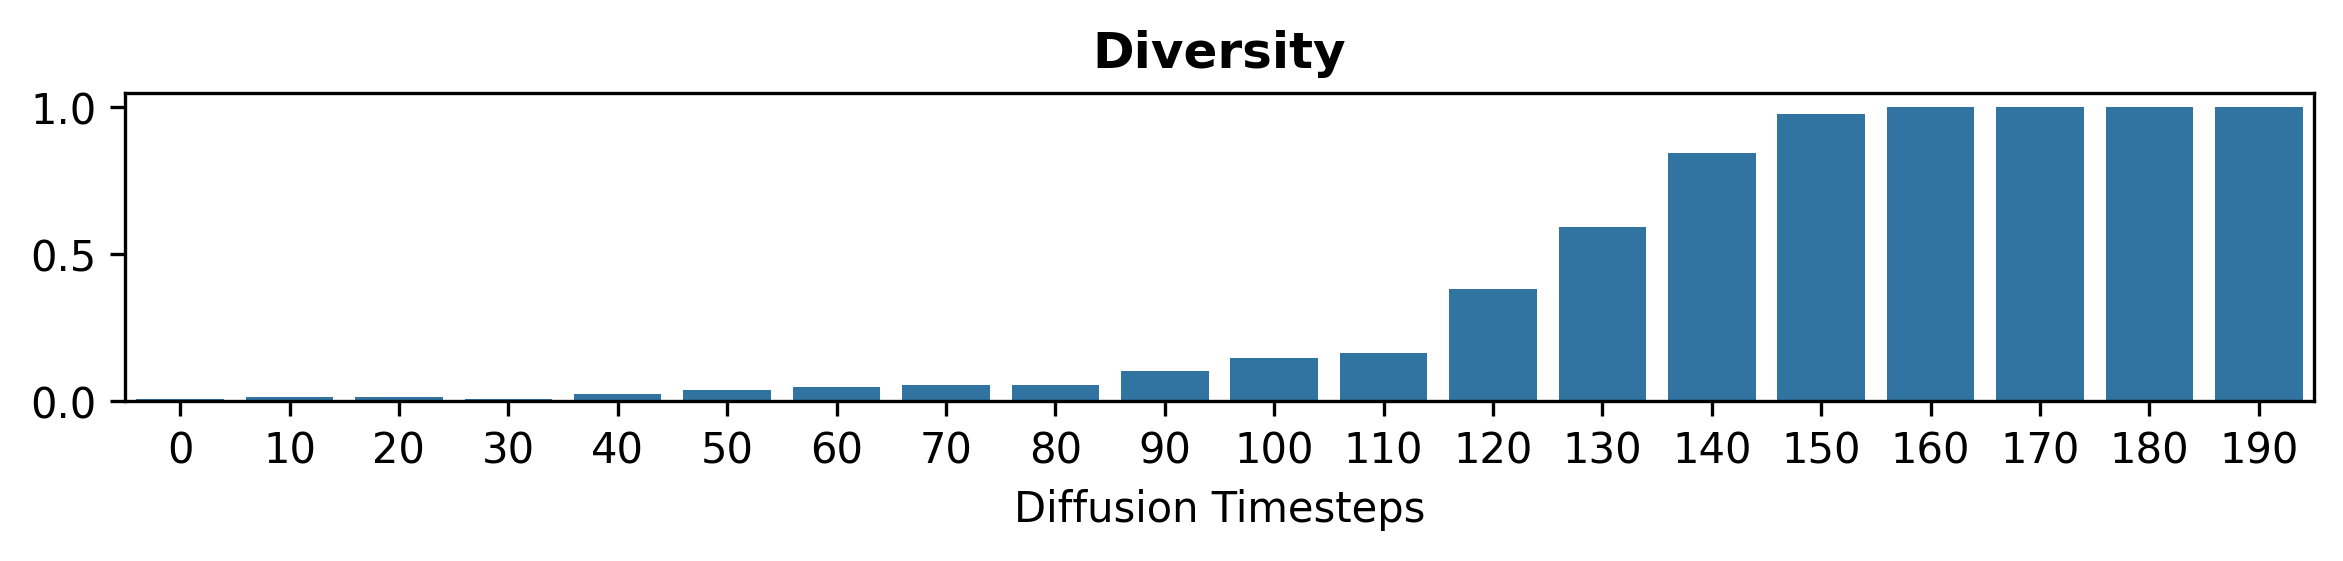

In [14]:
## diversity
plt.figure(figsize=(8, 2), dpi=300)
sns.barplot(x=list(range(0, 200, 10)), y=divers_ar,)
plt.xlabel('Diffusion Timesteps')
plt.ylabel(None)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
plt.title('Diversity', weight='bold')
plt.tight_layout()
plt.show()

In [15]:
divers_ar[np.where(np.array(list(range(0, 200, 10))) == 140)[0][0]]

0.84375

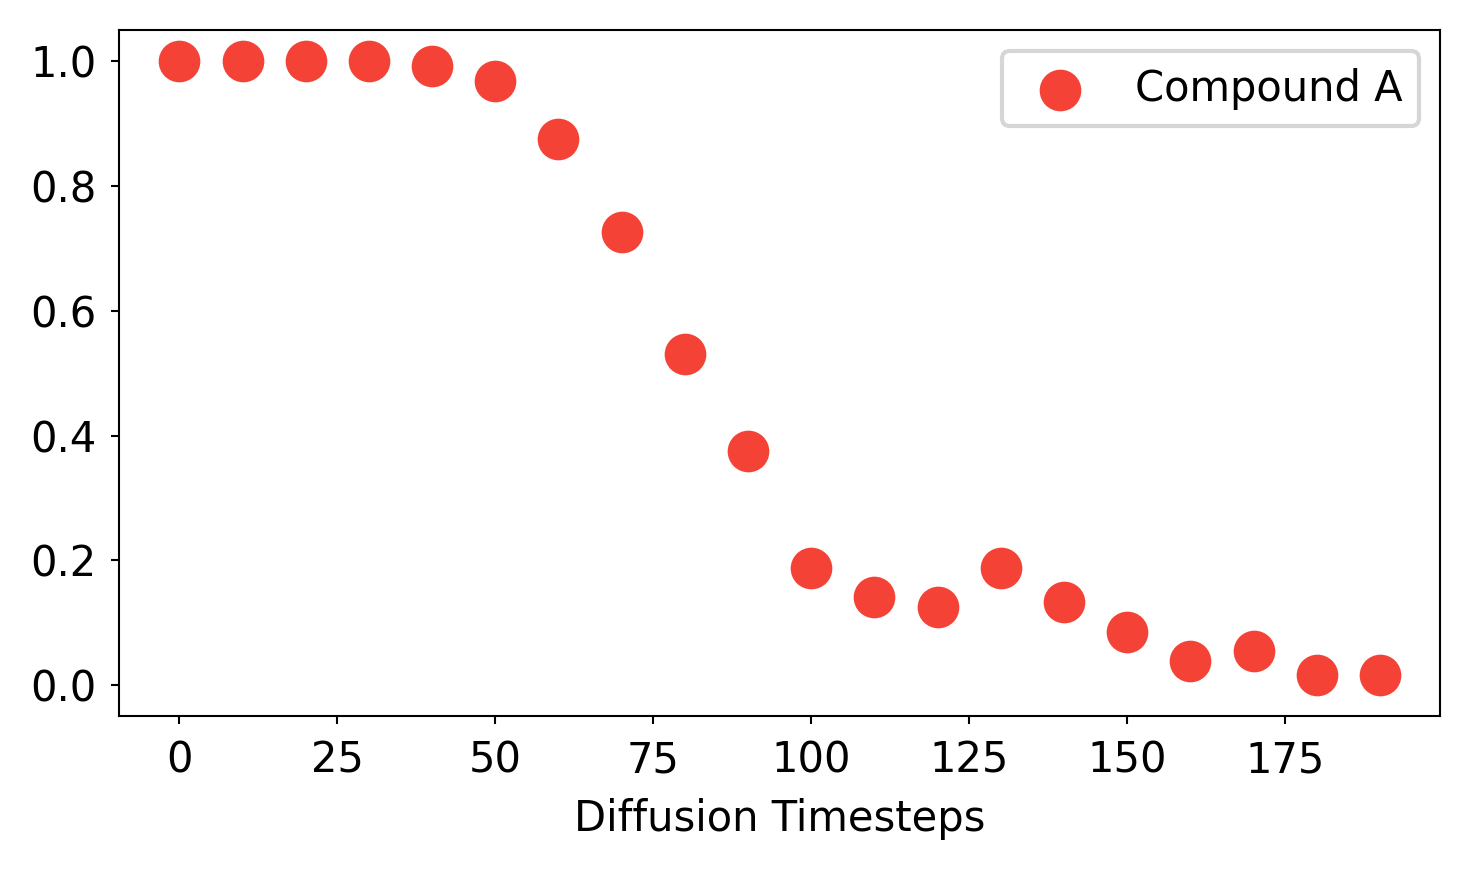

In [16]:
### have substructure
time_steps = np.arange(0, 200, 10)
dpi = 300
bwith = 0.5
colors = iter(['#F44336', '#4CAF50', '#1565C0'])

def plot_fn(accs, ax, label=''):
    c_ = next(colors)
    time_steps_fine = np.arange(0, 200, 500)
    ax.scatter(x=time_steps, y=accs, alpha=1., marker='o', label=label,
               edgecolors='w', linewidths=0, s=100, color=c_)


plt.figure(figsize=(5, 3), dpi=dpi)
ax = plt.gca()
ax.spines[:].set_linewidth(bwith)
ax.tick_params(axis='both', which='major', width=bwith, length=2)
plot_fn([np.mean(a) for a in has_subs_ar], ax, label='Compound A')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.xlabel('Diffusion Timesteps')
# plt.title('Reconstruction Accuracy', weight='bold')
plt.tight_layout()
plt.show()